# Zeropoint and sky Background and ADC counts for Auxtel

In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint

from scipy import interpolate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

In [2]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [3]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 

## Configuration

### Configuration of input path

In [4]:
atmosphere_std_filename = "atmos_std.dat"

hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]

hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]


filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Z","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

FILTERWL = np.array([[ 353.        ,  385.        ,  369.        ,   32.        ],
                  [ 393.        ,  560.        ,  476.5       ,  167.        ],
                  [ 557.        ,  703.        ,  630.        ,  146.        ],
                  [ 688.        ,  859.        ,  773.5       ,  171.        ],
                  [ 812.        ,  938.        ,  875.76271186,  126.        ],
                  [ 934.        , 1060.        ,  997.        ,  126.        ]])



### Configuration of telescope/camera photometric parameters

In [5]:
DT = 30.0 # seconds
gel = 1.08269375
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = 9636.0 # cm2  Reff=1.2 m
pixel_scale = 0.1 #arcsec/pixel
readnoise = 8.96875

def set_photometric_parameters(exptime, nexp, readnoise=readnoise):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [6]:
photoparams = set_photometric_parameters(DT, 1 , readnoise=readnoise )
photoparams._gain = gel
photoparams._exptime = DT
photoparams._effarea = A
photoparams._platescale = pixel_scale

## Read input files

In [7]:
!ls /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data/throughputs/auxtel

LSST_SDSS_Filters.xlsx
LSST_SDSS_Filters_g.xlsx
LSST_SDSS_Filters_i.xlsx
LSST_SDSS_Filters_r.xlsx
LSST_SDSS_Filters_y.xlsx
LSST_SDSS_Filters_z.xlsx
auxtel_sdss_g.dat
auxtel_sdss_gp.dat
auxtel_sdss_gp_total.dat
auxtel_sdss_i.dat
auxtel_sdss_ip.dat
auxtel_sdss_ip_total.dat
auxtel_sdss_r.dat
auxtel_sdss_rp.dat
auxtel_sdss_rp_total.dat
auxtel_sdss_u.dat
auxtel_sdss_up.dat
auxtel_sdss_up_total.dat
auxtel_sdss_yp.dat
auxtel_sdss_yp_total.dat
auxtel_sdss_z.dat
auxtel_sdss_zp.dat
auxtel_sdss_zp_total.dat
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [8]:
fdir = get_data_dir()
print(f"path for input data : {fdir}")
# path for Bandpass for lsstsim : throughputs/baseline
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')

path for input data : /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


### Atmospheric transmission

In [9]:
atm_fullfilename = os.path.join(fdir,'throughputs','baseline',atmosphere_std_filename)
arr= np.loadtxt(atm_fullfilename)
fatm = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
atm = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

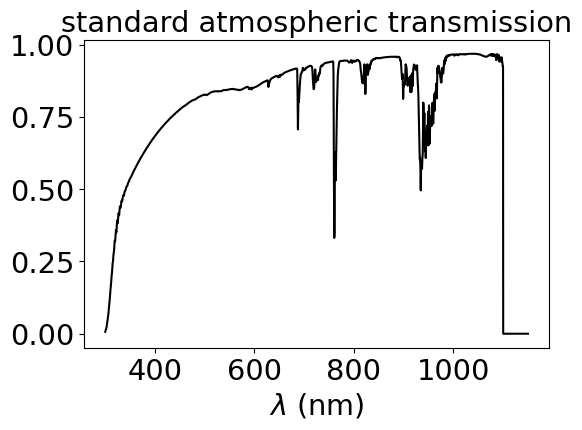

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(atm.wavelen,atm.sb,color="k")   
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_title("standard atmospheric transmission")
plt.show()

### Instrumental Filter , no atmosphere

In [11]:
bandpass_inst = {}
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

Text(0.5, 1.0, 'Instrument throughput')

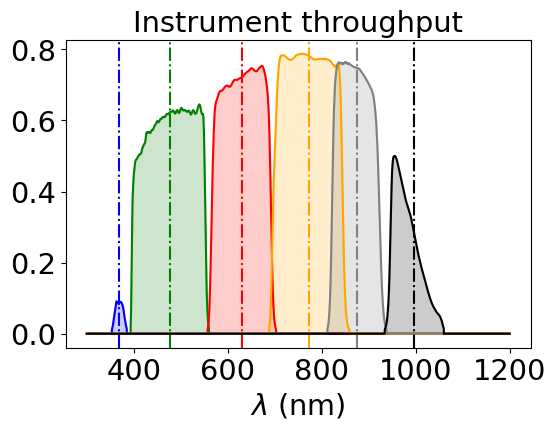

In [12]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")


### total Filter , with atmosphere

In [13]:
bandpass_total = {}
for index,filename in enumerate(total_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    ftr = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_total[fname] = Bandpass(wavelen=WL,sb=ftr(WL)*fatm(WL))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Total throughput')

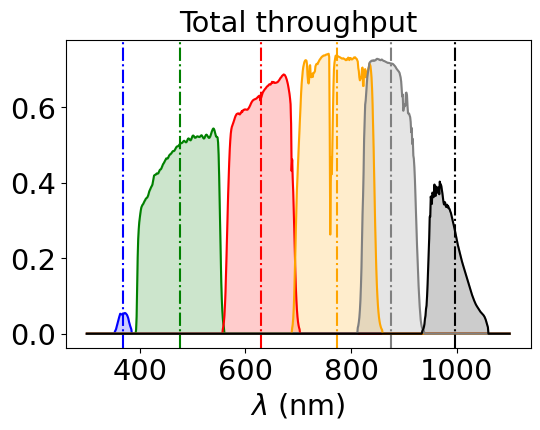

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total throughput")

## Zero Point

In [15]:
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 30.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [16]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
   
    zp = bandpass_total[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

,u,g,r,i,z,y
ZP (mag),24.21,28.39,28.16,28.23,27.66,26.46


## Sky Background

### Get Sky Spectrum
https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [17]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(fdir,'throughputs','baseline', 'darksky.dat'))

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

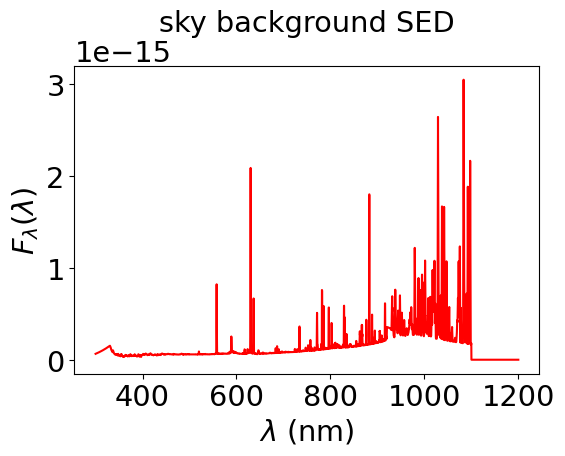

In [18]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
#axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

### Dark-Sky Magnitude

In [19]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    darksky_mags[f] = darksky.calc_mag(bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark-Sky mag/arcsec']).round(2)

,u,g,r,i,z,y
Dark-Sky mag/arcsec,23.16,22.28,21.17,20.34,19.59,18.57


### Dark-Sky ADU/sec

In [20]:
photoparams._exptime = 1. 
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [21]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu[f] = darksky.calc_adu(bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark-Sky ADU/pix/s']).round(2)

,u,g,r,i,z,y
Dark-Sky ADU/pix/s,0.15,11.71,23.75,52.84,60.72,54.87


### Dark-Sky ADU/exposure

In [22]:
photoparams._exptime = 30. 
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 30.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [23]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu_expo = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu_expo[f] = darksky.calc_adu(bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu_expo, index=['Dark-Sky ADU/pix/expo']).round(2)

,u,g,r,i,z,y
Dark-Sky ADU/pix/expo,4.38,351.41,712.54,1585.14,1821.52,1645.97
